 # importar librerias

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import tensorflow as tf
 
from tensorflow.keras.preprocessing import image

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, concatenate, MaxPooling2D, AveragePooling2D, Conv1D, Conv2D, BatchNormalization, Activation, Add, Flatten, Dense, Concatenate

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preparación de data

## Cargar datos

In [2]:
meta_data = pd.read_excel('data_preliminar_trabajo_de_grado.Xlsx')
labels= meta_data['id_referencia'].unique()
labels_train = [str(x) for x in labels ]
train= ImageDataGenerator() \
.flow_from_directory(directory='data_tg_fase1 - copia/train',target_size=(512, 512), classes=labels_train, batch_size=1)

Found 250 images belonging to 125 classes.


In [3]:
# separamos vimagenes de clasificador
x_train = []
y_train = []
labels_train = []

for i in range (0, len(train.labels)):
    x = np.squeeze(train[i][0])
    x_train.append(x)
    
    y = np.squeeze(train[i][1])
    y_train.append(y)
    
    labels = y.tolist()
    labels = labels.index(1)
    labels_train.append(labels)
    
x_train = np.array(x_train)
print(x_train.shape)
y_train = np.array(y_train)
print(y_train.shape)
labels_train = np.array(labels_train)
print(labels_train.shape)

(250, 512, 512, 3)
(250, 125)
(250,)


In [4]:
# función para graficar tripletas
def plot_triplet (triplet):
        plt.figure(figsize=(6, 2))
        for i in range (0, 3):
            plt.subplot(1, 3, i + 1  )
            plt.imshow(np.squeeze((triplet[i].astype('uint8'))))
            plt.xticks=([])
            plt.yticks([])
            plt.show()

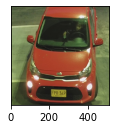

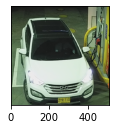

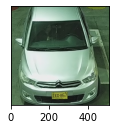

In [5]:
#prueba de función de plot_triplet
plot_triplet([x_train[0], x_train[1], x_train[2]])

In [6]:
# función para crear tripleta, 2 imagenes de la misma clasificación y 1 imagen de una clasificación diferente
def create_batch (batch_size=1, counter=0):
    anchors = np.zeros((batch_size, 512, 512, 3))
    positives = np.zeros((batch_size, 512, 512, 3))
    negatives = np.zeros((batch_size, 512, 512, 3))
    yy_train = np.zeros((batch_size, 125 ))
    
    for i in range(0, batch_size):
        anc = x_train[counter]
        yy = y_train[counter]
        y = labels_train[counter]
        
        indices_for_pos = np.squeeze(np.where(labels_train == y))
        indices_for_neg = np.squeeze(np.where(labels_train != y))
        
        pos = x_train[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        neg = x_train[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
    
        anchors[i] = anc
        positives[i] = pos
        negatives[i] = neg
        yy_train[i] = yy
            
    return [anchors, positives, negatives, yy_train]

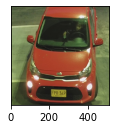

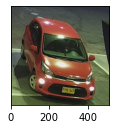

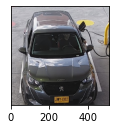

In [7]:
# muestra de tripleta
triplet = create_batch(1)[:3]
plot_triplet(triplet)

In [8]:
## función para generar dataset de entrenamiento
def data_generator (batch_size = 1, emb_dim=125):
    counter = 0
    while True:
        x = create_batch(batch_size, counter)[:3]
        y = create_batch(batch_size, counter)[-1]
        if counter < len(train.labels)-1 :
            counter = counter + 1
        else:
            counter = 0
        yield x, y

# Función de perdida

In [9]:
# cración de función de peridida triplet_loss, buscar la distancia entre 2 imagenes iguales y la comparación con una imagen diferente
def triplet_loss (alpha=0.3, poolsize=125):
    def loss (y_true, y_pred):
        anc, pos, neg = y_pred[:, :poolsize], y_pred[:, poolsize:2*poolsize], y_pred[:, 2*poolsize:]
        dp = tf.reduce_mean(tf.square(anc - pos), axis=1)
        dn = tf.reduce_mean(tf.square(anc - neg), axis=1)
        return tf.maximum(dp - dn + alpha, 0.)
    return loss

# Modelado

## creación del modelo

In [10]:
final_dim=125 

# ingreso de la tripleta, aunque esta red no tiene triplet_loss, se deja la configuración para cuando se haga el ensamble de todas las redes
in_anc = Input(shape=(512, 512, 3))
in_pos = Input(shape=(512, 512, 3))
in_neg = Input(shape=(512, 512, 3))
    
#Backbone 
rn50 =  ResNet50(weights= 'imagenet', include_top= False, input_shape= ( 512, 512, 3)) (in_anc)
        
# split the maxpooling layer, segmentación de imagen en 4 bloques
x = MaxPooling2D(pool_size= ( 4,16), strides= 4)(rn50)
x_1 = x[0:, :1, :,:]
x_2 = x[0:, 1:2, :, :]
x_3 = x[0:, 2:3, :, :]
x_4 = x[0:,3:, :,:]
        
# first skipconection
x_234 =  concatenate([x_2, x_3, x_4], axis=1)
x_234 = AveragePooling2D(pool_size=(3,1))(x_234)
x_234 = Conv2D(filters= 256, kernel_size= (1,1))(x_234)
cx_1 = Conv2D(filters= 256, kernel_size= (1,1))(x_1)
x_234 = concatenate([x_234, cx_1], axis=1)
x_234 = Conv2D(filters= 256, kernel_size= (1,1))(x_234)
x_234 = BatchNormalization()(x_234)
x_234 = Activation('relu')(x_234)
cx_1 = Add()([x_234, cx_1])
        
# second skipconection
x_134 =  concatenate([x_1, x_3, x_4], axis=1)
x_134 = AveragePooling2D(pool_size=(3,1))(x_134)
x_134 = Conv2D(filters= 256, kernel_size= (1,1))(x_134)
cx_2 = Conv2D(filters= 256, kernel_size= (1,1))(x_2)
x_134 = concatenate([x_134, cx_2], axis=1)
x_134 = Conv2D(filters= 256, kernel_size= (1,1))(x_134)
x_134 = BatchNormalization()(x_134)
x_134 = Activation('relu')(x_134)
cx_2 = Add()([x_134, cx_2])
        
# third skipconection
x_124 =  concatenate([x_1, x_2, x_4], axis=1)
x_124 = AveragePooling2D(pool_size=(3,1))(x_124)
x_124 = Conv2D(filters= 256, kernel_size= (1,1))(x_124)
cx_3 = Conv2D(filters= 256, kernel_size= (1,1))(x_3)
x_124 = concatenate([x_124, cx_3], axis=1)
x_124 = Conv2D(filters= 256, kernel_size= (1,1))(x_124)
x_124 = BatchNormalization()(x_124)
x_124 = Activation('relu')(x_124)
cx_3 = Add()([x_124, cx_3])
        
# fourth skipconection
x_123 =  concatenate([x_1, x_2, x_3], axis=1)
x_123 = AveragePooling2D(pool_size=(3,1))(x_123)
x_123 = Conv2D(filters= 256, kernel_size= (1,1))(x_123)
cx_4 = Conv2D(filters= 256, kernel_size= (1,1))(x_4)
x_123 = concatenate([x_123, cx_4], axis=1)
x_123 = Conv2D(filters= 256, kernel_size= (1,1))(x_123)
x_123 = BatchNormalization()(x_123)
x_123 = Activation('relu')(x_123)
cx_4 = Add()([x_123, cx_4])
        
##dense layer
conca = concatenate([cx_1, cx_2, cx_3, cx_4])
flatten = Flatten()(conca)
dense125 = Dense(units=final_dim, activation='softmax')(flatten)

#union del modelo
net_cb1 = Model([in_anc, in_pos, in_neg], dense125)
net_cb1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 16, 16, 2048  23587712    ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 4, 1, 2048)   0           ['resnet50[0][0]']               
                                                                                              

 concatenate_3 (Concatenate)    (None, 2, 1, 256)    0           ['conv2d_3[0][0]',               
                                                                  'conv2d_4[0][0]']               
                                                                                                  
 concatenate_5 (Concatenate)    (None, 2, 1, 256)    0           ['conv2d_6[0][0]',               
                                                                  'conv2d_7[0][0]']               
                                                                                                  
 concatenate_7 (Concatenate)    (None, 2, 1, 256)    0           ['conv2d_9[0][0]',               
                                                                  'conv2d_10[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)              (None, 2, 1, 256)    65792       ['concatenate_1[0][0]']          
          

## entrenamiento del modelo

In [11]:
batch_size = 1
epochs = 15
steps_per_epoch = int(250/batch_size)

net_cb1.compile(loss= 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

net_cb1.fit(data_generator(batch_size, emb_dim=125), epochs=epochs, steps_per_epoch=steps_per_epoch, verbose=True)

Epoch 1/15
250/250 [==============================] - 433s 2s/step - loss: 26.7035 - accuracy: 0.0000e+00
Epoch 2/15
250/250 [==============================] - 394s 2s/step - loss: 7.8794 - accuracy: 0.0000e+00
Epoch 3/15
250/250 [==============================] - 396s 2s/step - loss: 8.3540 - accuracy: 0.0040
Epoch 4/15
250/250 [==============================] - 408s 2s/step - loss: 8.4215 - accuracy: 0.0080
Epoch 5/15
250/250 [==============================] - 402s 2s/step - loss: 6.9090 - accuracy: 0.0120
Epoch 6/15
250/250 [==============================] - 400s 2s/step - loss: 5.8952 - accuracy: 0.0120
Epoch 7/15
250/250 [==============================] - 402s 2s/step - loss: 5.5573 - accuracy: 0.0280
Epoch 8/15
250/250 [==============================] - 397s 2s/step - loss: 5.3802 - accuracy: 0.0240
Epoch 9/15
250/250 [==============================] - 395s 2s/step - loss: 5.1160 - accuracy: 0.0280
Epoch 10/15
250/250 [==============================] - 398s 2s/step - loss: 5.4118